In [113]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
az.style.use(['science', 'arviz-doc'])

In [6]:
def generate_bass_adoption_data():
    """Generate synthetic EV adoption data using Bass diffusion model"""
    years = np.arange(2018, 2024)
    
    # True Bass parameters
    m_true = 50000  # Market potential
    p_true = 0.03   # Innovation coefficient
    q_true = 0.4    # Imitation coefficient
    
    # Bass model simulation
    adoption = []
    C_prev = 0
    
    for t in range(len(years)):
        if t == 0:
            new_adopters = p_true * m_true
        else:
            new_adopters = p_true * (m_true - C_prev) + (q_true / m_true) * C_prev * (m_true - C_prev)
        
        # Add some noise
        new_adopters += np.random.normal(0, new_adopters * 0.1)
        new_adopters = max(0, new_adopters)
        
        C_prev += new_adopters
        adoption.append(C_prev)
    
    adoption_data = pd.DataFrame({
        'year': years,
        'adopters': adoption,
        'new_adopters': np.insert(np.diff(adoption), 0, adoption[0])
    })
    
    return adoption_data, m_true, p_true, q_true

# Generate adoption data
adoption_data, m_true, p_true, q_true = generate_bass_adoption_data()
print("EV Adoption Data:")
print(adoption_data)

EV Adoption Data:
   year      adopters  new_adopters
0  2018   1274.265381   1274.265381
1  2019   3243.423872   1969.158491
2  2020   6172.167807   2928.743935
3  2021  10216.009646   4043.841839
4  2022  14689.341336   4473.331690
5  2023  20050.241951   5360.900615


In [4]:
def generate_hourly_charging_profiles():
    """Generate synthetic hourly charging profiles for weekdays and weekends by month"""
    
    # Create date range for one year
    dates = pd.date_range('2023-01-01', '2023-12-31', freq='H')
    
    # Initialize arrays for our variables
    n_points = len(dates)
    demand = np.zeros(n_points)
    arrivals = np.zeros(n_points)
    dwelling_time = np.zeros(n_points)
    
    # Base patterns for different contexts
    def get_base_pattern(hour, month, is_weekend):
        """Get base pattern for demand, arrivals, and dwelling time"""
        
        # Seasonal factors
        seasonal_factor = 1.0 + 0.2 * np.sin((month - 6) * np.pi / 6)  # Higher in summer
        
        if not is_weekend:
            # Weekday pattern
            demand_base = (
                (0.2 * np.exp(-((hour - 8) / 2)**2) +   # Morning peak
                 0.3 * np.exp(-((hour - 18) / 2)**2)) * # Evening peak
                seasonal_factor
            )
            arrival_rate = (
                (0.4 * np.exp(-((hour - 9) / 1.5)**2) + # Arrive at work
                 0.6 * np.exp(-((hour - 17) / 1.5)**2)) # Leave work
            )
            dwell_base = 4 + 2 * np.sin(hour * np.pi / 12)  # Longer during work hours
        else:
            # Weekend pattern
            demand_base = (
                0.4 * np.exp(-((hour - 14) / 3)**2) *    # Afternoon peak
                seasonal_factor
            )
            arrival_rate = 0.3 * np.exp(-((hour - 13) / 2)**2)  # Mid-day arrivals
            dwell_base = 2 + 1 * np.sin(hour * np.pi / 12)     # Shorter stays
        
        return demand_base, arrival_rate, dwell_base
    
    # Generate data for each hour
    for i, timestamp in enumerate(dates):
        hour = timestamp.hour
        month = timestamp.month
        is_weekend = timestamp.dayofweek >= 5
        
        demand_base, arrival_rate, dwell_base = get_base_pattern(hour, month, is_weekend)
        
        # Add noise and generate actual values
        demand[i] = max(0, np.random.normal(demand_base * 10, demand_base * 2))
        arrivals[i] = np.random.poisson(arrival_rate * 5 + 0.1)
        dwelling_time[i] = max(0.1, np.random.normal(dwell_base, dwell_base * 0.3))
    
    # Create DataFrame
    ev_data = pd.DataFrame({
        'timestamp': dates,
        'demand_kwh': demand,
        'arrivals': arrivals,
        'dwelling_time_hours': dwelling_time,
        'hour': [ts.hour for ts in dates],
        'month': [ts.month for ts in dates],
        'day_of_week': [ts.dayofweek for ts in dates],
        'is_weekend': [ts.dayofweek >= 5 for ts in dates],
        'day_type': ['weekend' if ts.dayofweek >= 5 else 'weekday' for ts in dates]
    })
    
    return ev_data

In [5]:
# Generate hourly charging data
ev_data = generate_hourly_charging_profiles()
print(f"Generated {len(ev_data)} hourly records")
print("\nSample of hourly data:")
print(ev_data.head(24))  # Show first day

Generated 8737 hourly records

Sample of hourly data:
             timestamp    demand_kwh  arrivals  dwelling_time_hours  hour  \
0  2023-01-01 00:00:00  1.364673e-09       0.0             2.144635     0   
1  2023-01-01 01:00:00  1.928973e-08       0.0             2.109269     1   
2  2023-01-01 02:00:00  2.827124e-07       0.0             3.844489     2   
3  2023-01-01 03:00:00  3.885670e-06       0.0             2.416701     3   
4  2023-01-01 04:00:00  6.018134e-05       0.0             1.438504     4   
5  2023-01-01 05:00:00  4.468957e-04       0.0             3.950850     5   
6  2023-01-01 06:00:00  3.352887e-03       1.0             3.153259     6   
7  2023-01-01 07:00:00  1.674689e-02       0.0             3.372747     7   
8  2023-01-01 08:00:00  5.130165e-02       0.0             3.498016     8   
9  2023-01-01 09:00:00  2.772163e-01       1.0             1.632741     9   
10 2023-01-01 10:00:00  6.447743e-01       0.0             1.647582    10   
11 2023-01-01 11:00:00

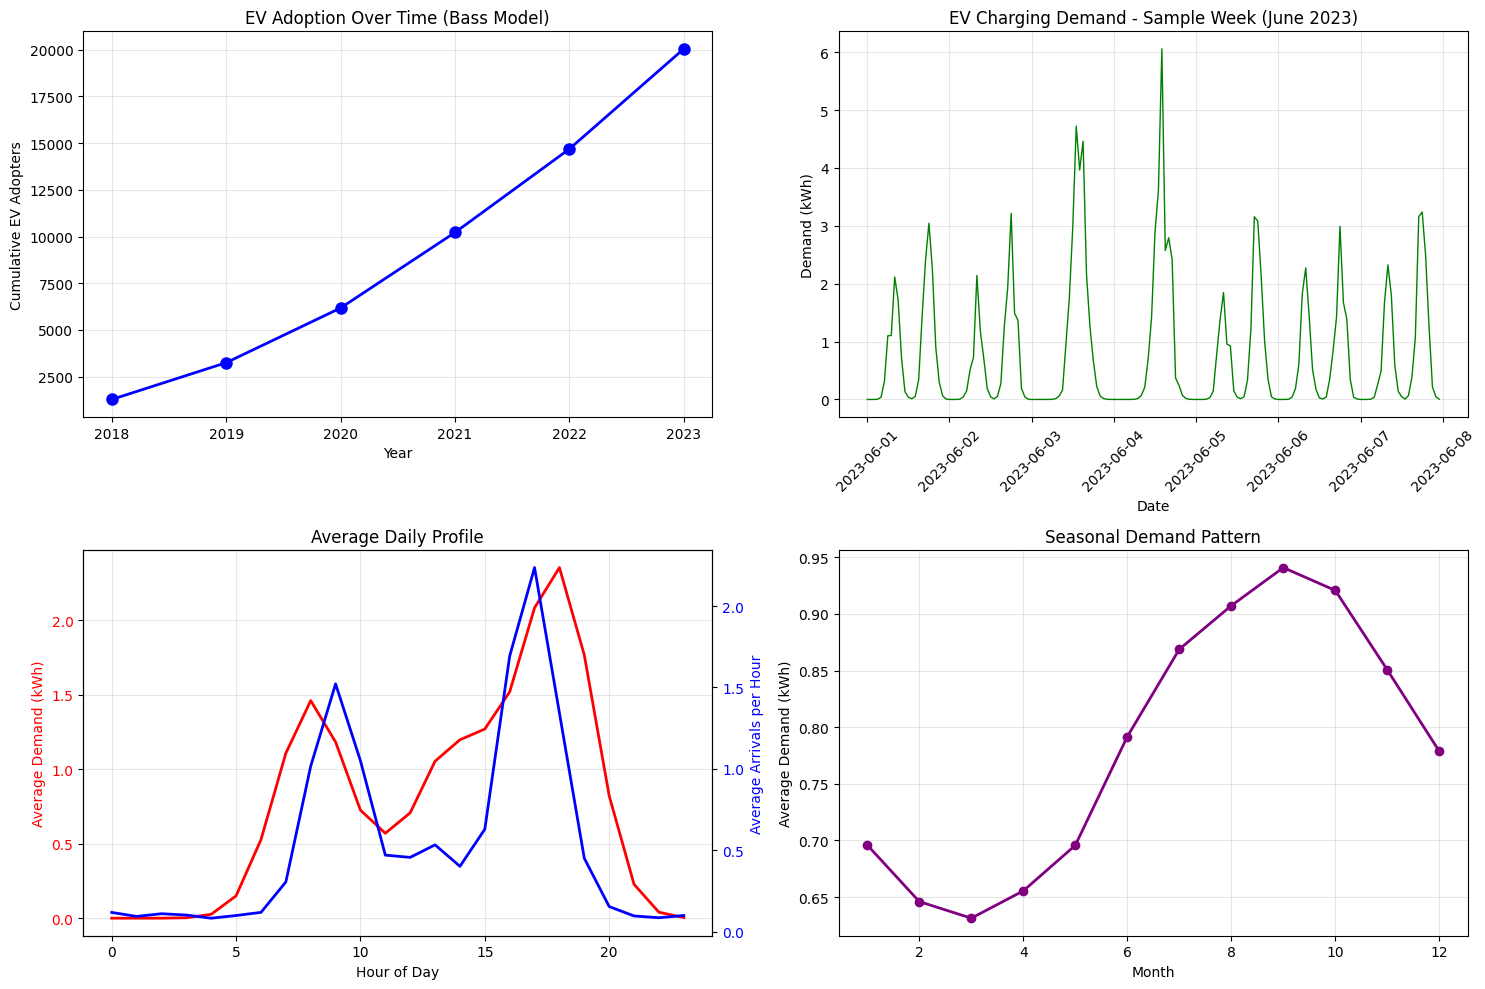

In [7]:
def plot_sample_data(ev_data, adoption_data):
    """Plot sample data to visualize patterns"""
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot 1: Adoption trend
    axes[0,0].plot(adoption_data['year'], adoption_data['adopters'], 'bo-', linewidth=2, markersize=8)
    axes[0,0].set_title('EV Adoption Over Time (Bass Model)')
    axes[0,0].set_xlabel('Year')
    axes[0,0].set_ylabel('Cumulative EV Adopters')
    axes[0,0].grid(True, alpha=0.3)
    
    # Plot 2: Sample week of demand
    sample_week = ev_data[(ev_data['timestamp'] >= '2023-06-01') & (ev_data['timestamp'] < '2023-06-08')]
    axes[0,1].plot(sample_week['timestamp'], sample_week['demand_kwh'], 'g-', linewidth=1)
    axes[0,1].set_title('EV Charging Demand - Sample Week (June 2023)')
    axes[0,1].set_xlabel('Date')
    axes[0,1].set_ylabel('Demand (kWh)')
    axes[0,1].tick_params(axis='x', rotation=45)
    axes[0,1].grid(True, alpha=0.3)
    
    # Plot 3: Average daily profile
    daily_profile = ev_data.groupby('hour').agg({
        'demand_kwh': 'mean',
        'arrivals': 'mean',
        'dwelling_time_hours': 'mean'
    }).reset_index()
    
    axes[1,0].plot(daily_profile['hour'], daily_profile['demand_kwh'], 'r-', label='Demand', linewidth=2)
    axes[1,0].set_xlabel('Hour of Day')
    axes[1,0].set_ylabel('Average Demand (kWh)', color='r')
    axes[1,0].tick_params(axis='y', labelcolor='r')
    axes[1,0].set_title('Average Daily Profile')
    axes[1,0].grid(True, alpha=0.3)
    
    ax2 = axes[1,0].twinx()
    ax2.plot(daily_profile['hour'], daily_profile['arrivals'], 'b-', label='Arrivals', linewidth=2)
    ax2.set_ylabel('Average Arrivals per Hour', color='b')
    ax2.tick_params(axis='y', labelcolor='b')
    
    # Plot 4: Seasonal pattern
    monthly_demand = ev_data.groupby('month')['demand_kwh'].mean()
    axes[1,1].plot(monthly_demand.index, monthly_demand.values, 'purple', linewidth=2, marker='o')
    axes[1,1].set_title('Seasonal Demand Pattern')
    axes[1,1].set_xlabel('Month')
    axes[1,1].set_ylabel('Average Demand (kWh)')
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_sample_data(ev_data, adoption_data)

In [8]:
def prepare_ev_data(df):
    """
    Prepare historical EV data for modeling
    Expected columns: timestamp, demand, dwelling_time, arrival_time
    """
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['hour'] = df['timestamp'].dt.hour
    df['day_of_week'] = df['timestamp'].dt.dayofweek
    df['month'] = df['timestamp'].dt.month
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    df['day_type'] = df['is_weekend'].apply(lambda x: 'weekend' if x else 'weekday')
    
    return df


In [10]:
df=prepare_ev_data(ev_data)

In [25]:
def build_hourly_model(observed_data, name, positive_only=False):
    """
    Helper function to build hourly models with consistent structure.
    Defined outside the loop for efficiency.
    """
    with pm.Model() as model:
        # Hyperpriors
        mu_sigma = pm.HalfNormal(f'mu_sigma_{name}', 1)
        hour_sigma = pm.HalfNormal(f'hour_sigma_{name}', 1)
        
        # Hour effects (hierarchical prior)
        hour_effects = pm.Normal(f'hour_effects_{name}', mu=0, sigma=hour_sigma, shape=24)
        
        # Global mean (prior centered on the data's mean)
        base_value = pm.Normal(f'base_{name}', mu=observed_data.mean(), sigma=mu_sigma)
        
        # Expected values for each hour
        mu_values = pm.Deterministic(f'mu_{name}', base_value + hour_effects)
        
        # Observation noise
        sigma_value = pm.HalfNormal(f'sigma_{name}', 1)
        
        # Likelihood
        if positive_only:
            # Note: For observed data that is strictly positive (like demand/dwell),
            # a LogNormal or Gamma distribution is often a better choice than a Normal.
            # Using HalfNormal for the likelihood is unconventional.
            # Let's stick to your original logic for now.
            pm.HalfNormal(f'obs_{name}', sigma=sigma_value, observed=observed_data)
        else:
            pm.Normal(f'obs_{name}', mu=mu_values, sigma=sigma_value, observed=observed_data)
            
    print(f"Model for {name} built with positive_only={positive_only}")
    return model

def build_hourly_profile_model_consistent(ev_data):
    """
    Build probabilistic models using identical structure for all variables.
    """
    models = {}
    
    # Group data by month and day type
    grouped = ev_data.groupby(['month', 'day_type'])
    
    for (month, day_type), group_data in grouped:
        print(f"Building model for month {month}, {day_type}")
        
        # Aggregate data by hour
        hourly_agg = group_data.groupby('hour').agg({
            'demand_kwh': 'mean',
            'arrivals': 'sum',
            'dwelling_time_hours': 'mean'
        }).reset_index()
        
        # Fill missing hours to ensure a complete 24-hour profile
        full_hours = pd.DataFrame({'hour': range(24)})
        hourly_agg = full_hours.merge(hourly_agg, on='hour', how='left').fillna(0)
        
        # Extract clean, homogeneous numpy arrays
        hourly_demand = hourly_agg['demand_kwh'].values
        hourly_arrivals = hourly_agg['arrivals'].values
        hourly_dwell = hourly_agg['dwelling_time_hours'].values
        
        # Build all three models using the helper function
        # For demand and dwell, consider a Gamma or LogNormal likelihood if values are always positive
        models[f'demand_{month}_{day_type}'] = build_hourly_model(hourly_demand, 'demand', positive_only=False)
        
        # For arrivals (count data), a Poisson or NegativeBinomial likelihood is usually best
        models[f'arrival_{month}_{day_type}'] = build_hourly_model(hourly_arrivals, 'arrivals', positive_only=False)
        
        models[f'dwell_{month}_{day_type}'] = build_hourly_model(hourly_dwell, 'dwell', positive_only=False)
    
    return models

In [27]:
models=build_hourly_profile_model_consistent(df.copy())

Building model for month 1, weekday
Model for demand built with positive_only=False
Model for arrivals built with positive_only=False
Model for dwell built with positive_only=False
Building model for month 1, weekend
Model for demand built with positive_only=False
Model for arrivals built with positive_only=False
Model for dwell built with positive_only=False
Building model for month 2, weekday
Model for demand built with positive_only=False
Model for arrivals built with positive_only=False
Model for dwell built with positive_only=False
Building model for month 2, weekend
Model for demand built with positive_only=False
Model for arrivals built with positive_only=False
Model for dwell built with positive_only=False
Building model for month 3, weekday
Model for demand built with positive_only=False
Model for arrivals built with positive_only=False
Model for dwell built with positive_only=False
Building model for month 3, weekend
Model for demand built with positive_only=False
Model for a

In [86]:
import pytensor.tensor as pt # <--- IMPORT PYTENSOR


def build_bass_model(historical_adoption_data, future_years=15):
    """
    Build Bayesian Bass diffusion model for adoption data.
    
    The model assumes 'adopters' column contains the CUMULATIVE number of adoptions.
    The likelihood is defined on the new adopters (the difference between periods)
    using a Negative Binomial distribution to better handle count data and overdispersion.
    """
    
    with pm.Model() as bass_model:
        # Priors for Bass parameters
        m = pm.Lognormal('m', mu=np.log(1e6), sigma=2)  # Market potential
        p = pm.Beta('p', alpha=2, beta=10, initval=0.01)  # Innovation coefficient (p/q < 1 is typical)
        q = pm.Beta('q', alpha=2, beta=2, initval=0.4)   # Imitation coefficient
        
        # Historical setup
        # t_hist is the index for model dynamics (starting at 0 for the first period)
        historical_adopters = historical_adoption_data['adopters'].values
        n_hist = len(historical_adopters)
        
        # C_hist will store the cumulative adoptions predicted by the model (size n_hist)
        # Initialize C[0] with the initial observed adoption (usually historical_adopters[0])
        C_hist = pt.zeros(n_hist, dtype='float64')
        C_hist = pt.set_subtensor(C_hist[0], historical_adopters[0])
        
        # Bass model dynamics - Calculating cumulative adoptions C_hist
        # Loop starts at the second period (index 1)
        for i in range(1, n_hist):
            prev_C = C_hist[i-1]
            
            # Bass Differential Equation: dC/dt = (p + q * C/m) * (m - C)
            # The next period's new adopters (N_new)
            innovation = p * (m - prev_C)
            imitation = (q / m) * prev_C * (m - prev_C)
            
            new_adopters_model = innovation + imitation
            
            # Update cumulative adopters: C[i] = C[i-1] + N_new
            C_hist = pt.set_subtensor(C_hist[i], prev_C + new_adopters_model)

        # --- Likelihood Calculation (Comparing New Adopters) ---
        
        # Model's new adopters (N_model) - difference of cumulative predictions
        N_model = C_hist[1:] - C_hist[:-1] 
        
        # Observed new adopters (N_observed) - difference of cumulative historical data
        # MUST BE CONVERTED TO INTEGER for NegativeBinomial
        N_observed = (historical_adopters[1:] - historical_adopters[:-1]).astype(int)
        
        # Likelihood: Switched from Normal to Negative Binomial for count data
        # mu=N_model (the mean expected count), alpha=dispersion parameter
        alpha = pm.HalfCauchy("alpha", 1) # Dispersion parameter for NegBinom
        pm.NegativeBinomial('obs', mu=N_model, alpha=alpha, observed=N_observed)
        
        # --- Forecasting (Future years) ---
        
        t_future = np.arange(n_hist, n_hist + future_years)
        # C_future will store the *full* forecasted cumulative curve (size n_hist + future_years)
        # Initialize C_forecast with C_hist
        C_forecast = pt.concatenate([C_hist, pt.zeros(future_years, dtype='float64')])
        
        # Start forecasting from n_hist (the first forecast period)
        for i in range(n_hist, n_hist + future_years):
            prev_C = C_forecast[i-1]
            
            innovation = p * (m - prev_C)
            imitation = (q / m) * prev_C * (m - prev_C)
            new_adopters = innovation + imitation
            
            C_forecast = pt.set_subtensor(C_forecast[i], prev_C + new_adopters)
        
        # Deterministics for analysis
        pm.Deterministic('N_model_hist', N_model)
        pm.Deterministic('C_hist_model', C_hist)
        pm.Deterministic('C_forecast', C_forecast)
        pm.Deterministic('N_forecast', C_forecast[n_hist:] - C_forecast[n_hist-1:-1]) # New adopters forecast
        
    return bass_model

In [100]:
def build_gbass_model(historical_adoption_data, future_years=15):
    """
    Build Bayesian Generalized Bass diffusion model for adoption data.
    
    The model uses a Negative Binomial likelihood and allows the imitation
    coefficient (q) to be modulated by a 'marketing_index' external factor.
    
    The model assumes 'adopters' is cumulative.
    """
    
    with pm.Model() as bass_model:
        # Priors for Bass parameters
        m = pm.Lognormal('m', mu=np.log(1e6), sigma=2)  # Market potential
        p = pm.Beta('p', alpha=2, beta=10, initval=0.01)  # Innovation coefficient
        q = pm.Beta('q', alpha=2, beta=2, initval=0.4)   # Baseline Imitation coefficient
        
        # New Priors for GBM - External Factor Effect
        beta_q = pm.Normal('beta_q', mu=0, sigma=0.5)  # Coefficient for marketing effect on q
        
        # Historical setup
        historical_adopters = historical_adoption_data['adopters'].values
        marketing_index = historical_adoption_data['marketing_index'].values
        n_hist = len(historical_adopters)
        
        # C_hist will store the cumulative adoptions predicted by the model (size n_hist)
        # Initialize C[0] with the initial observed adoption
        C_hist = pt.zeros(n_hist, dtype='float64')
        C_hist = pt.set_subtensor(C_hist[0], historical_adopters[0])
        
        # Bass model dynamics - Calculating cumulative adoptions C_hist
        # Loop starts at the second period (index 1)
        for i in range(1, n_hist):
            prev_C = C_hist[i-1]
            
            # 1. Generalized Imitation Coefficient (q_eff)
            # Use marketing index from the *previous* period (index i-1) to influence adoption in period i
            # pt.clip ensures q_eff stays non-negative for stable simulation
            q_eff = pt.clip(q + beta_q * marketing_index[i-1], 1e-6, 1.0)
            
            # 2. Bass Model Dynamics with GBM
            innovation = p * (m - prev_C)
            # Use q_eff in the imitation term
            imitation = (q_eff / m) * prev_C * (m - prev_C)
            
            new_adopters_model = innovation + imitation
            
            # Update cumulative adopters: C[i] = C[i-1] + N_new
            C_hist = pt.set_subtensor(C_hist[i], prev_C + new_adopters_model)

        # --- Likelihood Calculation (Comparing New Adopters) ---
        
        # Model's new adopters (N_model) - difference of cumulative predictions
        N_model = C_hist[1:] - C_hist[:-1] 
        
        # Observed new adopters (N_observed) - difference of cumulative historical data
        N_observed = (historical_adopters[1:] - historical_adopters[:-1]).astype(int)
        
        # Likelihood: Negative Binomial for count data
        alpha = pm.HalfCauchy("alpha", 1) # Dispersion parameter for NegBinom
        pm.NegativeBinomial('obs', mu=N_model, alpha=alpha, observed=N_observed)
        
        # --- Forecasting (Future years) ---
        
        # Future marketing index: Assume it stays constant at the last observed level
        # If you have a real marketing plan, replace this with that data!
        last_marketing = marketing_index[-1]
        marketing_future = np.repeat(last_marketing, future_years)
        marketing_full = np.concatenate([marketing_index, marketing_future])
        
        
        C_forecast = pt.concatenate([C_hist, pt.zeros(future_years, dtype='float64')])
        
        # Start forecasting from n_hist (the first forecast period)
        for i in range(n_hist, n_hist + future_years):
            prev_C = C_forecast[i-1]
            
            # Use future marketing index (index i-1 in the full marketing_full array)
            q_eff = pt.clip(q + beta_q * marketing_full[i-1], 1e-6, 1.0)
            
            innovation = p * (m - prev_C)
            imitation = (q_eff / m) * prev_C * (m - prev_C)
            new_adopters = innovation + imitation
            
            C_forecast = pt.set_subtensor(C_forecast[i], prev_C + new_adopters)
        
        # Deterministics for analysis
        pm.Deterministic('N_model_hist', N_model)
        pm.Deterministic('C_hist_model', C_hist)
        pm.Deterministic('C_forecast', C_forecast)
        pm.Deterministic('N_forecast', C_forecast[n_hist:] - C_forecast[n_hist-1:-1]) # New adopters forecast
        
    return bass_model

# --- 2. Setup Mock Data and Run Fit (for demonstration) ---

# Mock Historical Data (assuming 'adopters' is CUMULATIVE)
mock_data = {
    'year': np.arange(2015, 2026), # 11 years
    'adopters': np.array([50, 150, 350, 700, 1200, 1900, 2900, 4200, 5800, 7500, 9500]),
    # NEW: Mock marketing index (e.g., standardized marketing spend/effort)
    'marketing_index': np.array([0.1, 0.2, 0.3, 0.5, 0.4, 0.6, 0.7, 0.75, 0.8, 0.65, 0.5])
}
historical_adoption_data = pd.DataFrame(mock_data)

# Build and fit the model
print("Building and fitting the PyMC GBM model...")
bass_gmodel = build_gbass_model(historical_adoption_data, future_years=15)

Building and fitting the PyMC GBM model...


In [101]:
idata = pm.sample(
        model=bass_gmodel, 
        draws=1000, 
        tune=1000, 
        chains=2, 
        cores=2,
        target_accept=0.9
    )

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [m, p, q, beta_q, alpha]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 11 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details



--- 3.1 Convergence Diagnostics (R-hat and ESS) ---


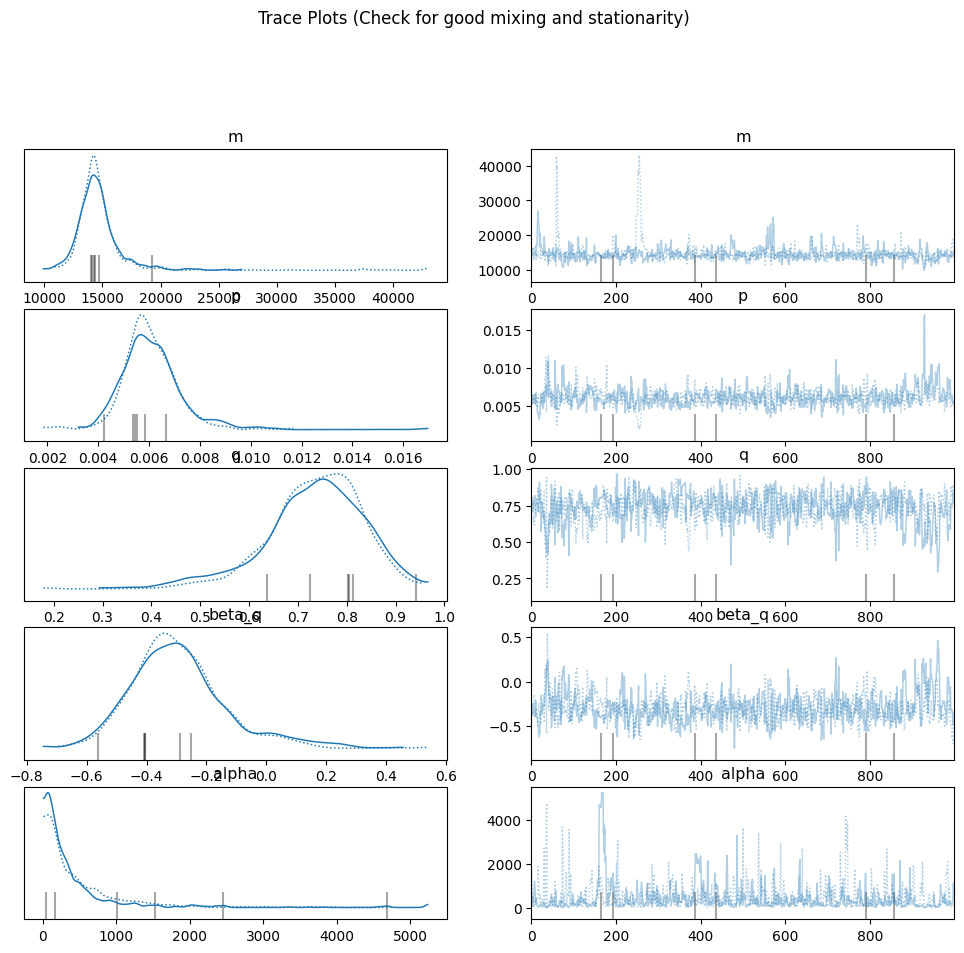

In [103]:
# Check R-hat and Effective Sample Size (ESS)
print("\n--- 3.1 Convergence Diagnostics (R-hat and ESS) ---")
# Added 'beta_q' to the summary and trace plots
az.plot_trace(idata, var_names=['m', 'p', 'q', 'beta_q', 'alpha']);
plt.suptitle('Trace Plots (Check for good mixing and stationarity)', y=1.02)
plt.show()


--- 4.2 Parameter Posterior Distributions ---


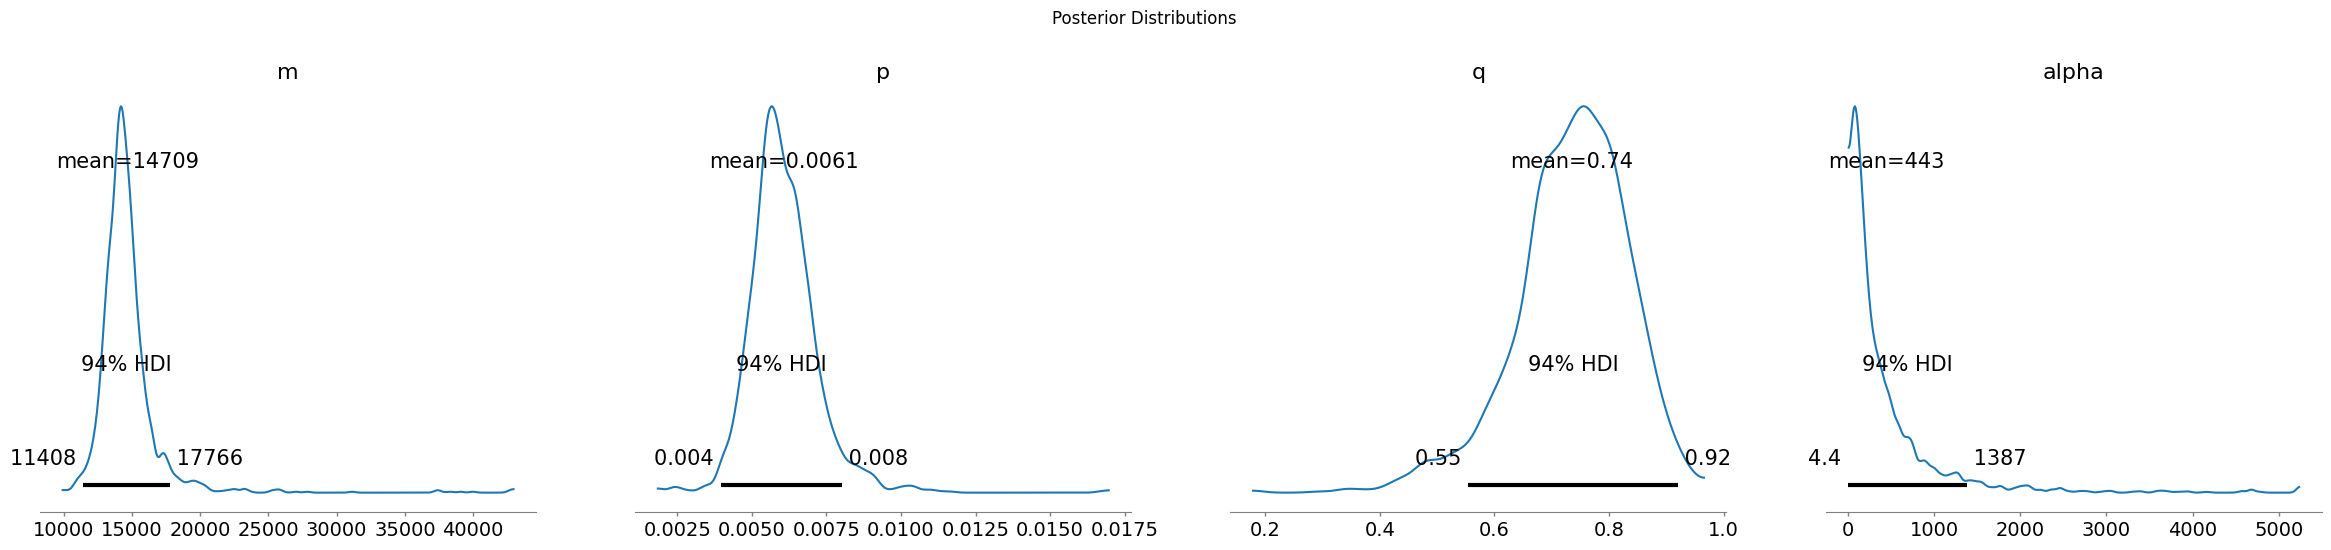

In [104]:
print("\n--- 4.2 Parameter Posterior Distributions ---")
az.plot_posterior(idata, var_names=['m', 'p', 'q', 'alpha']);
plt.suptitle('Posterior Distributions', y=1.02)
plt.show()


--- 5.1 Historical Fit (Posterior Predictive Check) ---


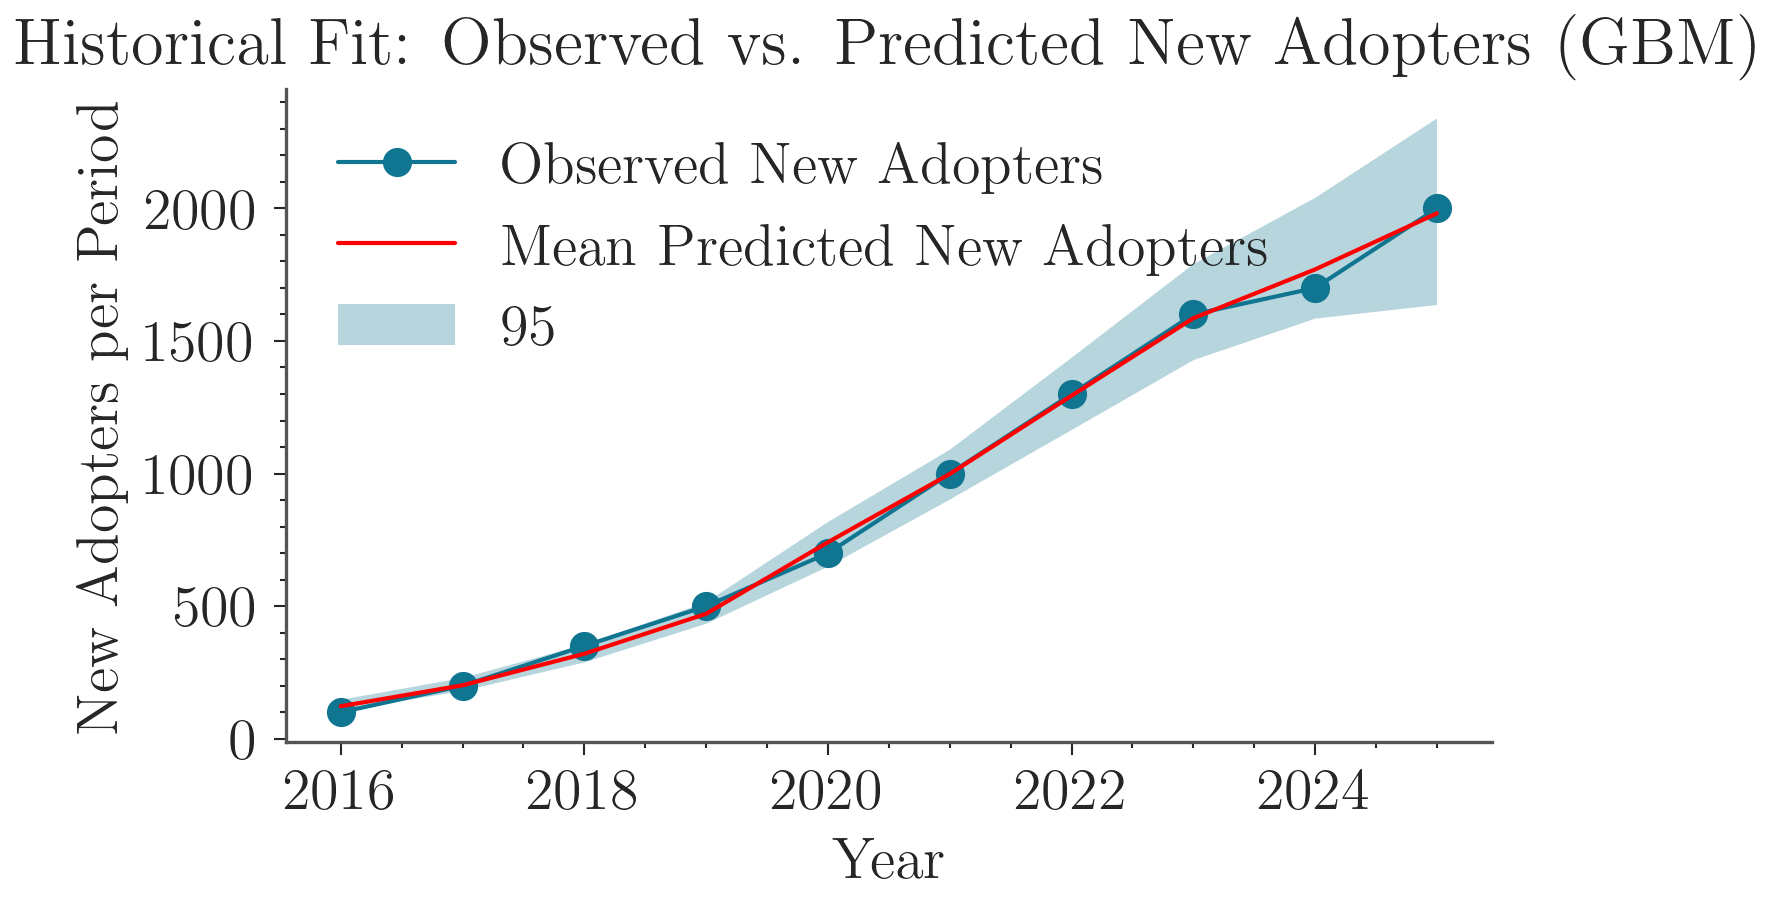

In [115]:
print("\n--- 5.1 Historical Fit (Posterior Predictive Check) ---")
fig, ax = plt.subplots(figsize=(4.8, 3))

# Plot observed new adopters
N_observed = historical_adoption_data['adopters'].diff().iloc[1:]
N_mean = idata.posterior['N_model_hist'].mean(dim=['chain', 'draw'])
ax.plot(historical_adoption_data['year'].iloc[1:], N_observed, 'o-',  label='Observed New Adopters')
ax.plot(historical_adoption_data['year'].iloc[1:], N_mean, color='red', label='Mean Predicted New Adopters')
ax.fill_between(historical_adoption_data['year'].iloc[1:], 
                    idata.posterior['N_model_hist'].quantile(0.025, dim=('chain', 'draw')),
                    idata.posterior['N_model_hist'].quantile(0.975, dim=('chain', 'draw')),
                    alpha=0.3, label='95% CI')
ax.set_title('Historical Fit: Observed vs. Predicted New Adopters (GBM)')
ax.set_xlabel('Year')
ax.set_ylabel('New Adopters per Period')
ax.legend()
plt.show()


--- 5.2 Forecast Visualization (Cumulative Adopters) ---


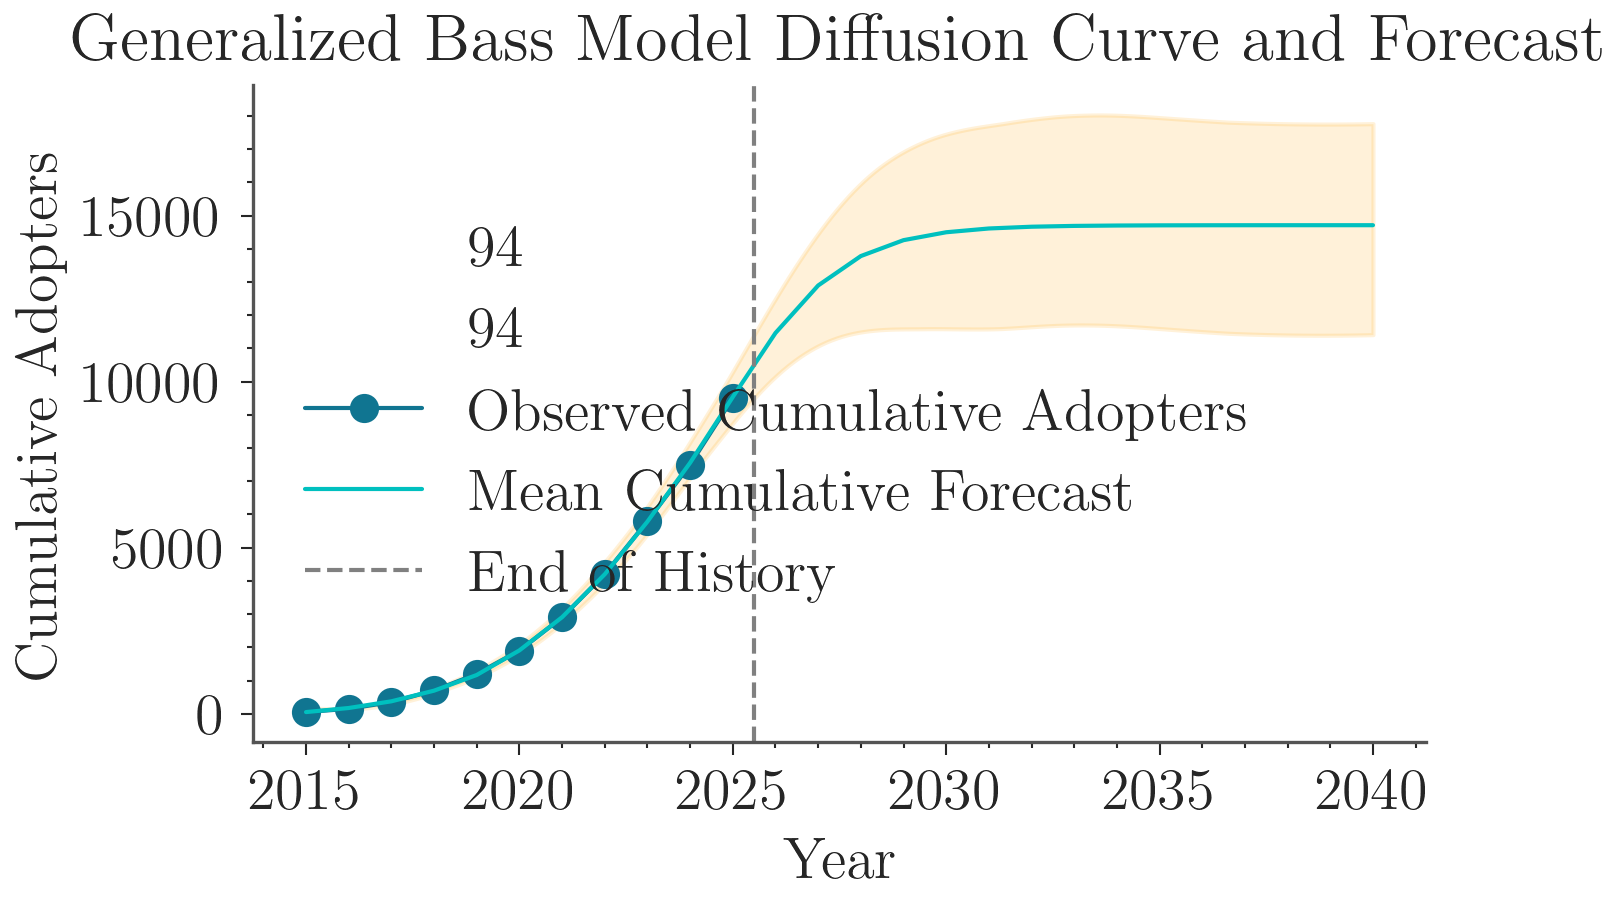

In [129]:
print("\n--- 5.2 Forecast Visualization (Cumulative Adopters) ---")
fig, ax = plt.subplots(figsize=(4.8, 3.0))
future_years=15
# Historical Years
hist_years = historical_adoption_data['year'].values
# Forecasted Years
forecast_years = np.arange(hist_years[-1] + 1, hist_years[-1] + future_years + 1)
all_years = np.concatenate([hist_years, forecast_years])
az.plot_hdi(
    all_years, 
    idata.posterior['C_forecast'], 
    ax=ax, 
    hdi_prob=0.94,
    color='orange',
    fill_kwargs={'alpha': 0.15}, 
    plot_kwargs={'ls': '-', 'label': '94% HDI Cumulative Forecast'}
)
# Plot observed cumulative data
ax.plot(hist_years, historical_adoption_data['adopters'], 'o-', label='Observed Cumulative Adopters')
C_mean_full = idata.posterior['C_forecast'].mean(dim=['chain', 'draw'])
ax.plot(all_years, C_mean_full, label='Mean Cumulative Forecast')
ax.axvline(hist_years[-1] + 0.5, color='gray', linestyle='--', label='End of History')
ax.set_title('Generalized Bass Model Diffusion Curve and Forecast')
ax.set_xlabel('Year')
ax.set_ylabel('Cumulative Adopters')
ax.legend()
plt.show()

In [87]:
bass_model =  build_bass_model(adoption_data)
with bass_model:
    bass_trace = pm.sample(1000, tune=1000, chains=2, target_accept=0.9)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [m, p, q, alpha]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [88]:
## Basic Model Diagnostics
def analyze_bass_model(trace, model, historical_data, future_years=15):
    """
    Comprehensive analysis of the fitted Bass model
    """
    
    # 1. Convergence diagnostics
    print("=== CONVERGENCE DIAGNOSTICS ===")
    print(az.summary(trace, var_names=['m', 'p', 'q', 'sigma']))
    
    # Check R-hat values (should be < 1.1)
    rhats = az.rhat(trace)
    print(f"\nR-hat values:")
    for param in ['m', 'p', 'q', 'sigma']:
        print(f"  {param}: {rhats[param].values:.3f}")
    
    # 2. Trace plots to check mixing
    print("\n=== TRACE PLOTS ===")
    az.plot_trace(trace, var_names=['m', 'p', 'q', 'sigma'])
    plt.tight_layout()
    plt.show()

In [89]:
#Parameter Interpretation & Business Sense
def interpret_bass_parameters(trace, historical_data):
    """
    Interpret Bass parameters in business context
    """
    # Extract posterior samples
    m_samples = trace.posterior['m'].values.flatten()
    p_samples = trace.posterior['p'].values.flatten()
    q_samples = trace.posterior['q'].values.flatten()
    
    print("=== BASS PARAMETER INTERPRETATION ===")
    
    # Market potential (m)
    print(f"Market Potential (m):")
    print(f"  Mean: {m_samples.mean():,.0f} EVs")
    print(f"  95% CI: [{np.percentile(m_samples, 2.5):,.0f}, {np.percentile(m_samples, 97.5):,.0f}]")
    
    # Compare with current adoption
    current_adoption = historical_data['adopters'].iloc[-1]
    print(f"  Current adoption: {current_adoption:,.0f} EVs")
    print(f"  Remaining market: {m_samples.mean() - current_adoption:,.0f} EVs")
    
    # Innovation coefficient (p)
    print(f"\nInnovation Coefficient (p):")
    print(f"  Mean: {p_samples.mean():.4f}")
    print(f"  95% CI: [{np.percentile(p_samples, 2.5):.4f}, {np.percentile(p_samples, 97.5):.4f}]")
    
    # Imitation coefficient (q)
    print(f"\nImitation Coefficient (q):")
    print(f"  Mean: {q_samples.mean():.4f}")
    print(f"  95% CI: [{np.percentile(q_samples, 2.5):.4f}, {np.percentile(q_samples, 97.5):.4f}]")
    
    # Calculate peak adoption time
    def calculate_peak_time(p, q):
        return np.log(q) - np.log(p) / (p + q) if p > 0 and q > 0 else np.nan
    
    peak_times = [calculate_peak_time(p, q) for p, q in zip(p_samples, q_samples)]
    peak_times = [t for t in peak_times if not np.isnan(t)]
    
    if peak_times:
        print(f"\nPeak Adoption Time:")
        print(f"  Mean: {np.mean(peak_times):.2f} years from start")
        print(f"  95% CI: [{np.percentile(peak_times, 2.5):.2f}, {np.percentile(peak_times, 97.5):.2f}]")
    
    return m_samples, p_samples, q_samples

In [90]:
def assess_model_fit(trace, model, historical_data):
    """
    Assess how well the model fits historical data
    """
    print("\n=== MODEL FIT ASSESSMENT ===")
    
    # Posterior predictive checks
    with model:
        ppc = pm.sample_posterior_predictive(trace)
    
    # Extract observed and predicted values
    observed = historical_data['adopters'].values[1:]  # Skip first period due to differencing
    predicted = ppc.posterior_predictive['obs'].mean(dim=('chain', 'draw'))
    
    # Calculate metrics
    mae = np.mean(np.abs(predicted - observed))
    rmse = np.sqrt(np.mean((predicted - observed)**2))
    mape = np.mean(np.abs((predicted - observed) / observed)) * 100
    
    print(f"Fit Metrics:")
    print(f"  MAE: {mae:.2f} adopters")
    print(f"  RMSE: {rmse:.2f} adopters") 
    print(f"  MAPE: {mape:.2f}%")
    
    # Plot fit
    plt.figure(figsize=(12, 6))
    
    # Historical period
    years_hist = historical_data['year'].values[1:]
    
    plt.subplot(1, 2, 1)
    plt.plot(years_hist, observed, 'o-', label='Observed', linewidth=2)
    plt.plot(years_hist, predicted, 's--', label='Predicted', alpha=0.7)
    plt.fill_between(years_hist, 
                    ppc.posterior_predictive['obs'].quantile(0.025, dim=('chain', 'draw')),
                    ppc.posterior_predictive['obs'].quantile(0.975, dim=('chain', 'draw')),
                    alpha=0.3, label='95% CI')
    plt.xlabel('Year')
    plt.ylabel('New Adopters')
    plt.title('Model Fit - Historical Data')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    return ppc

In [83]:
def analyze_forecasts(trace, historical_data, future_years=15):
    print("\n=== FORECAST ANALYSIS ===")

    # Extract future cumulative forecasts
    C_future = trace.posterior['C_future']

    # Calculate yearly new adopters, handling dimension matching
    # Use the same method you used for historical data
    new_adopters_future = C_future.diff(dim='C_future_dim_0')  # This creates a (14,) array

    # Create future years - ensure this matches new_adopters_future length
    last_historical_year = historical_data['year'].iloc[-1]
    # Start from last_historical_year + 1 because differencing reduces count
    future_years_range = range(last_historical_year + 1, last_historical_year + future_years) # Note: now 14 years

    # Calculate summary statistics on the differenced data
    forecast_mean = new_adopters_future.mean(dim=('chain', 'draw'))
    forecast_upper = new_adopters_future.quantile(0.975, dim=('chain', 'draw'))
    forecast_lower = new_adopters_future.quantile(0.025, dim=('chain', 'draw'))
    # Plot forecasts
    plt.subplot(1, 2, 2)
    
    # Historical data for context
    years_hist = historical_data['year'].values[1:]
    observed_hist = historical_data['adopters'].values[1:] - historical_data['adopters'].values[:-1]
    
    plt.plot(years_hist, observed_hist, 'o-', color='blue', label='Historical', linewidth=2)
    plt.plot(future_years_range, forecast_mean, 's-', color='red', label='Forecast Mean')
    plt.fill_between(future_years_range, forecast_lower, forecast_upper, 
                    alpha=0.3, color='red', label='95% CI')
    
    plt.xlabel('Year')
    plt.ylabel('New Adopters')
    plt.title('EV Adoption Forecast')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Print key forecast metrics
    print("Forecast Summary:")
    for i, year in enumerate(future_years_range[:5]):  # Show first 5 years
        print(f"  {year}: {forecast_mean[i].values:.0f} ± {(forecast_upper[i] - forecast_lower[i]).values/2:.0f} new adopters")
    
    # Total forecasted adoption
    total_forecast = C_future.isel(C_future_dim_0=-1).mean().item()
    print(f"\nTotal forecasted adoption in {future_years} years: {total_forecast:,.0f} EVs")
    
    return new_adopters_future

In [84]:
def complete_bass_analysis(trace, model, historical_data, future_years=15):
    """
    Run complete Bass model analysis
    """
    print("🧪 BASS MODEL ANALYSIS REPORT")
    print("=" * 50)
    
    # 1. Basic diagnostics
    analyze_bass_model(trace, model, historical_data)
    
    # 2. Parameter interpretation
    m, p, q = interpret_bass_parameters(trace, historical_data)
    
    # 3. Model fit assessment
    ppc = assess_model_fit(trace, model, historical_data)
    
    # 4. Forecast analysis
    forecasts = analyze_forecasts(trace, historical_data, future_years)
    
    # 5. Sensitivity analysis
    print("\n=== SENSITIVITY ANALYSIS ===")
    print("Parameter Correlations:")
    param_samples = np.column_stack([m, p, q])
    corr_matrix = np.corrcoef(param_samples.T)
    param_names = ['m', 'p', 'q']
    for i in range(len(param_names)):
        for j in range(i+1, len(param_names)):
            print(f"  {param_names[i]} vs {param_names[j]}: {corr_matrix[i,j]:.3f}")
    
    return {
        'parameters': {'m': m, 'p': p, 'q': q},
        'ppc': ppc,
        'forecasts': forecasts
    }

In [91]:
# Run complete analysis
results = complete_bass_analysis(bass_trace, bass_model, adoption_data)

# Check if parameters make business sense
m_mean = results['parameters']['m'].mean()
p_mean = results['parameters']['p'].mean() 
q_mean = results['parameters']['q'].mean()

print(f"\n💡 BUSINESS SENSE CHECK:")
print(f"Market size reasonable? {'✓' if m_mean > adoption_data['adopters'].iloc[-1] else '✗'}")
print(f"Innovation rate reasonable? {'✓' if 0.001 < p_mean < 0.1 else '✗'} (typical: 0.01-0.03)")
print(f"Imitation rate reasonable? {'✓' if 0.2 < q_mean < 0.8 else '✗'} (typical: 0.3-0.5)")


🧪 BASS MODEL ANALYSIS REPORT
=== CONVERGENCE DIAGNOSTICS ===


KeyError: 'var names: "[\'sigma\'] are not present" in dataset'

In [ ]:
class EVChargingForecaster:
    def __init__(self, ev_data, historical_adoption_data):
        self.ev_data = ev_data
        self.historical_adoption_data = historical_adoption_data
        self.hourly_models = None
        self.bass_model = None
        self.hourly_traces = {}
        self.bass_trace = None
        
    def fit_hourly_models(self, samples=1000, tune=1000):
        """Fit all hourly profile models"""
        print("Fitting hourly profile models...")
        self.hourly_models = build_hourly_profile_model_consistent(self.ev_data)
        
        for name, model in self.hourly_models.items():
            print(f"Sampling {name}...")
            with model:
                trace = pm.sample(samples, tune=tune, chains=2, target_accept=0.9)
                self.hourly_traces[name] = trace
                
    def fit_bass_model(self, samples=2000, tune=1000):
        """Fit Bass diffusion model"""
        print("Fitting Bass diffusion model...")
        self.bass_model = build_bass_model_simple(self.historical_adoption_data)
        
        with self.bass_model:
            self.bass_trace = pm.sample(samples, tune=tune, chains=2, target_accept=0.9)
            
    def get_hourly_profiles(self):
        """Extract posterior distributions for hourly profiles"""
        profiles = {}
        
        for name, trace in self.hourly_traces.items():
            model_type, month, day_type = name.split('_')
            month = int(month)
            
            if model_type == 'demand':
                # Get posterior demand distributions
                hourly_demand = trace.posterior['mu_demand'].mean(dim=('chain', 'draw'))
                profiles[(month, day_type, 'demand')] = hourly_demand.values
                
            elif model_type == 'arrival':
                # Get posterior arrival rates
                arrival_rates = trace.posterior['arrival_rates'].mean(dim=('chain', 'draw'))
                profiles[(month, day_type, 'arrival')] = arrival_rates.values
                
            elif model_type == 'dwell':
                # Get posterior dwelling time parameters
                alpha = trace.posterior['alpha_dwell'].mean(dim=('chain', 'draw'))
                beta = trace.posterior['beta_dwell'].mean(dim=('chain', 'draw'))
                profiles[(month, day_type, 'dwell_alpha')] = alpha.values
                profiles[(month, day_type, 'dwell_beta')] = beta.values
                
        return profiles
    
    def project_future_demand(self, target_year, month, day_type, hour):
        """Project demand for a specific future timestamp"""
        # Get scaling factor from Bass model
        future_years = target_year - self.historical_adoption_data['year'].max()
        if future_years <= 0:
            raise ValueError("Target year must be in the future")
            
        # Get adoption forecast
        adoption_forecast = self.bass_trace.posterior['C_future'].sel(chain=0, draw=0)
        scaling_factor = adoption_forecast.isel(C_future_dim_0=future_years-1).values / \
                        self.historical_adoption_data['adopters'].iloc[-1]
        
        # Get base profile
        base_demand = self.get_hourly_profiles()[(month, day_type, 'demand')][hour]
        
        # Apply scaling
        projected_demand = base_demand * scaling_factor
        
        return projected_demand, scaling_factor
    
    def generate_complete_forecast(self, target_year):
        """Generate complete forecast for a target year"""
        forecast = {}
        
        for month in range(1, 13):
            for day_type in ['weekday', 'weekend']:
                for hour in range(24):
                    key = (month, day_type, hour)
                    demand, scaling = self.project_future_demand(target_year, month, day_type, hour)
                    forecast[key] = {
                        'demand': demand,
                        'scaling_factor': scaling,
                        'year': target_year
                    }
                    
        return forecast

In [33]:
forecaster = EVChargingForecaster(df, adoption_data)
    
# Fit models
forecaster.fit_hourly_models(samples=1000, tune=1000)
forecaster.fit_bass_model(samples=2000, tune=1000)

Fitting hourly profile models...
Building model for month 1, weekday
Model for demand built with positive_only=False
Model for arrivals built with positive_only=False
Model for dwell built with positive_only=False
Building model for month 1, weekend
Model for demand built with positive_only=False
Model for arrivals built with positive_only=False
Model for dwell built with positive_only=False
Building model for month 2, weekday
Model for demand built with positive_only=False
Model for arrivals built with positive_only=False
Model for dwell built with positive_only=False
Building model for month 2, weekend
Model for demand built with positive_only=False
Model for arrivals built with positive_only=False
Model for dwell built with positive_only=False
Building model for month 3, weekday
Model for demand built with positive_only=False
Model for arrivals built with positive_only=False
Model for dwell built with positive_only=False
Building model for month 3, weekend
Model for demand built wit

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_sigma_demand, hour_sigma_demand, hour_effects_demand, base_demand, sigma_demand]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
There were 134 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...


Sampling arrival_1_weekday...


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_sigma_arrivals, hour_sigma_arrivals, hour_effects_arrivals, base_arrivals, sigma_arrivals]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...


Sampling dwell_1_weekday...


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_sigma_dwell, hour_sigma_dwell, hour_effects_dwell, base_dwell, sigma_dwell]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...


Sampling demand_1_weekend...


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_sigma_demand, hour_sigma_demand, hour_effects_demand, base_demand, sigma_demand]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
There were 149 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...


Sampling arrival_1_weekend...


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_sigma_arrivals, hour_sigma_arrivals, hour_effects_arrivals, base_arrivals, sigma_arrivals]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
There were 73 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...


Sampling dwell_1_weekend...


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_sigma_dwell, hour_sigma_dwell, hour_effects_dwell, base_dwell, sigma_dwell]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
There were 72 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...


Sampling demand_2_weekday...


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_sigma_demand, hour_sigma_demand, hour_effects_demand, base_demand, sigma_demand]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...


Sampling arrival_2_weekday...


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_sigma_arrivals, hour_sigma_arrivals, hour_effects_arrivals, base_arrivals, sigma_arrivals]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.
There were 72 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...


Sampling dwell_2_weekday...


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_sigma_dwell, hour_sigma_dwell, hour_effects_dwell, base_dwell, sigma_dwell]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Sampling demand_2_weekend...


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_sigma_demand, hour_sigma_demand, hour_effects_demand, base_demand, sigma_demand]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...


Sampling arrival_2_weekend...


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_sigma_arrivals, hour_sigma_arrivals, hour_effects_arrivals, base_arrivals, sigma_arrivals]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...


Sampling dwell_2_weekend...


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_sigma_dwell, hour_sigma_dwell, hour_effects_dwell, base_dwell, sigma_dwell]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...


Sampling demand_3_weekday...


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_sigma_demand, hour_sigma_demand, hour_effects_demand, base_demand, sigma_demand]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...


Sampling arrival_3_weekday...


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_sigma_arrivals, hour_sigma_arrivals, hour_effects_arrivals, base_arrivals, sigma_arrivals]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.
There were 158 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...


Sampling dwell_3_weekday...


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_sigma_dwell, hour_sigma_dwell, hour_effects_dwell, base_dwell, sigma_dwell]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
There were 98 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...


Sampling demand_3_weekend...


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_sigma_demand, hour_sigma_demand, hour_effects_demand, base_demand, sigma_demand]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...


Sampling arrival_3_weekend...


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_sigma_arrivals, hour_sigma_arrivals, hour_effects_arrivals, base_arrivals, sigma_arrivals]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
There were 51 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...


Sampling dwell_3_weekend...


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_sigma_dwell, hour_sigma_dwell, hour_effects_dwell, base_dwell, sigma_dwell]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
There were 45 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...


Sampling demand_4_weekday...


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_sigma_demand, hour_sigma_demand, hour_effects_demand, base_demand, sigma_demand]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
There were 152 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...


Sampling arrival_4_weekday...


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_sigma_arrivals, hour_sigma_arrivals, hour_effects_arrivals, base_arrivals, sigma_arrivals]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...


Sampling dwell_4_weekday...


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_sigma_dwell, hour_sigma_dwell, hour_effects_dwell, base_dwell, sigma_dwell]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
There were 55 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...


Sampling demand_4_weekend...


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_sigma_demand, hour_sigma_demand, hour_effects_demand, base_demand, sigma_demand]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
There were 58 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...


Sampling arrival_4_weekend...


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_sigma_arrivals, hour_sigma_arrivals, hour_effects_arrivals, base_arrivals, sigma_arrivals]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
There were 104 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...


Sampling dwell_4_weekend...


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_sigma_dwell, hour_sigma_dwell, hour_effects_dwell, base_dwell, sigma_dwell]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...


Sampling demand_5_weekday...


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_sigma_demand, hour_sigma_demand, hour_effects_demand, base_demand, sigma_demand]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
There were 81 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...


Sampling arrival_5_weekday...


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_sigma_arrivals, hour_sigma_arrivals, hour_effects_arrivals, base_arrivals, sigma_arrivals]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.
There were 93 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...


Sampling dwell_5_weekday...


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_sigma_dwell, hour_sigma_dwell, hour_effects_dwell, base_dwell, sigma_dwell]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
There were 366 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Sampling demand_5_weekend...


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_sigma_demand, hour_sigma_demand, hour_effects_demand, base_demand, sigma_demand]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
There were 62 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...


Sampling arrival_5_weekend...


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_sigma_arrivals, hour_sigma_arrivals, hour_effects_arrivals, base_arrivals, sigma_arrivals]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...


Sampling dwell_5_weekend...


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_sigma_dwell, hour_sigma_dwell, hour_effects_dwell, base_dwell, sigma_dwell]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
There were 135 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...


Sampling demand_6_weekday...


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_sigma_demand, hour_sigma_demand, hour_effects_demand, base_demand, sigma_demand]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
There were 263 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...


Sampling arrival_6_weekday...


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_sigma_arrivals, hour_sigma_arrivals, hour_effects_arrivals, base_arrivals, sigma_arrivals]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...


Sampling dwell_6_weekday...


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_sigma_dwell, hour_sigma_dwell, hour_effects_dwell, base_dwell, sigma_dwell]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...


Sampling demand_6_weekend...


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_sigma_demand, hour_sigma_demand, hour_effects_demand, base_demand, sigma_demand]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
There were 72 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...


Sampling arrival_6_weekend...


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_sigma_arrivals, hour_sigma_arrivals, hour_effects_arrivals, base_arrivals, sigma_arrivals]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.
There were 64 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Sampling dwell_6_weekend...


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_sigma_dwell, hour_sigma_dwell, hour_effects_dwell, base_dwell, sigma_dwell]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
There were 74 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...


Sampling demand_7_weekday...


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_sigma_demand, hour_sigma_demand, hour_effects_demand, base_demand, sigma_demand]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...


Sampling arrival_7_weekday...


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_sigma_arrivals, hour_sigma_arrivals, hour_effects_arrivals, base_arrivals, sigma_arrivals]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.
There were 89 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...


Sampling dwell_7_weekday...


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_sigma_dwell, hour_sigma_dwell, hour_effects_dwell, base_dwell, sigma_dwell]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...


Sampling demand_7_weekend...


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_sigma_demand, hour_sigma_demand, hour_effects_demand, base_demand, sigma_demand]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
There were 54 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Sampling arrival_7_weekend...


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_sigma_arrivals, hour_sigma_arrivals, hour_effects_arrivals, base_arrivals, sigma_arrivals]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.
There were 65 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...


Sampling dwell_7_weekend...


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_sigma_dwell, hour_sigma_dwell, hour_effects_dwell, base_dwell, sigma_dwell]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
There were 72 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...


Sampling demand_8_weekday...


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_sigma_demand, hour_sigma_demand, hour_effects_demand, base_demand, sigma_demand]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...


Sampling arrival_8_weekday...


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_sigma_arrivals, hour_sigma_arrivals, hour_effects_arrivals, base_arrivals, sigma_arrivals]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...


Sampling dwell_8_weekday...


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_sigma_dwell, hour_sigma_dwell, hour_effects_dwell, base_dwell, sigma_dwell]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
There were 58 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Sampling demand_8_weekend...


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_sigma_demand, hour_sigma_demand, hour_effects_demand, base_demand, sigma_demand]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
There were 85 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...


Sampling arrival_8_weekend...


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_sigma_arrivals, hour_sigma_arrivals, hour_effects_arrivals, base_arrivals, sigma_arrivals]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.
There were 82 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...


Sampling dwell_8_weekend...


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_sigma_dwell, hour_sigma_dwell, hour_effects_dwell, base_dwell, sigma_dwell]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
There were 77 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...


Sampling demand_9_weekday...


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_sigma_demand, hour_sigma_demand, hour_effects_demand, base_demand, sigma_demand]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...


Sampling arrival_9_weekday...


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_sigma_arrivals, hour_sigma_arrivals, hour_effects_arrivals, base_arrivals, sigma_arrivals]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.
There were 238 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...


Sampling dwell_9_weekday...


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_sigma_dwell, hour_sigma_dwell, hour_effects_dwell, base_dwell, sigma_dwell]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...


Sampling demand_9_weekend...


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_sigma_demand, hour_sigma_demand, hour_effects_demand, base_demand, sigma_demand]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...


Sampling arrival_9_weekend...


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_sigma_arrivals, hour_sigma_arrivals, hour_effects_arrivals, base_arrivals, sigma_arrivals]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
There were 56 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...


Sampling dwell_9_weekend...


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_sigma_dwell, hour_sigma_dwell, hour_effects_dwell, base_dwell, sigma_dwell]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...


Sampling demand_10_weekday...


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_sigma_demand, hour_sigma_demand, hour_effects_demand, base_demand, sigma_demand]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
There were 53 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...


Sampling arrival_10_weekday...


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_sigma_arrivals, hour_sigma_arrivals, hour_effects_arrivals, base_arrivals, sigma_arrivals]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...


Sampling dwell_10_weekday...


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_sigma_dwell, hour_sigma_dwell, hour_effects_dwell, base_dwell, sigma_dwell]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
There were 57 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...


Sampling demand_10_weekend...


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_sigma_demand, hour_sigma_demand, hour_effects_demand, base_demand, sigma_demand]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
There were 58 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...


Sampling arrival_10_weekend...


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_sigma_arrivals, hour_sigma_arrivals, hour_effects_arrivals, base_arrivals, sigma_arrivals]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.
There were 82 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...


Sampling dwell_10_weekend...


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_sigma_dwell, hour_sigma_dwell, hour_effects_dwell, base_dwell, sigma_dwell]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...


Sampling demand_11_weekday...


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_sigma_demand, hour_sigma_demand, hour_effects_demand, base_demand, sigma_demand]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
There were 61 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Sampling arrival_11_weekday...


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_sigma_arrivals, hour_sigma_arrivals, hour_effects_arrivals, base_arrivals, sigma_arrivals]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
There were 113 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...


Sampling dwell_11_weekday...


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_sigma_dwell, hour_sigma_dwell, hour_effects_dwell, base_dwell, sigma_dwell]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
There were 62 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...


Sampling demand_11_weekend...


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_sigma_demand, hour_sigma_demand, hour_effects_demand, base_demand, sigma_demand]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...


Sampling arrival_11_weekend...


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_sigma_arrivals, hour_sigma_arrivals, hour_effects_arrivals, base_arrivals, sigma_arrivals]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
There were 86 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...


Sampling dwell_11_weekend...


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_sigma_dwell, hour_sigma_dwell, hour_effects_dwell, base_dwell, sigma_dwell]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
There were 60 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...


Sampling demand_12_weekday...


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_sigma_demand, hour_sigma_demand, hour_effects_demand, base_demand, sigma_demand]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
There were 84 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...


Sampling arrival_12_weekday...


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_sigma_arrivals, hour_sigma_arrivals, hour_effects_arrivals, base_arrivals, sigma_arrivals]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.
There were 812 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...


Sampling dwell_12_weekday...


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_sigma_dwell, hour_sigma_dwell, hour_effects_dwell, base_dwell, sigma_dwell]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Sampling demand_12_weekend...


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_sigma_demand, hour_sigma_demand, hour_effects_demand, base_demand, sigma_demand]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
There were 103 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...


Sampling arrival_12_weekend...


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_sigma_arrivals, hour_sigma_arrivals, hour_effects_arrivals, base_arrivals, sigma_arrivals]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Sampling dwell_12_weekend...


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_sigma_dwell, hour_sigma_dwell, hour_effects_dwell, base_dwell, sigma_dwell]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Fitting Bass diffusion model...


ValueError: Incompatible Elemwise input shapes [(5,), (6,)]

In [34]:
def build_unified_hourly_model(ev_data):
    """
    Builds ONE hierarchical model for all hourly profiles.
    This is much faster and statistically more robust.
    """
    # 1. Prepare data and create coordinate mappings
    df = ev_data.copy()
    df['month_idx'], months = pd.factorize(df['month'])
    df['day_type_idx'], day_types = pd.factorize(df['day_type'])
    df['hour_idx'], hours = pd.factorize(df['hour'])

    coords = {
        'month': months,
        'day_type': day_types,
        'hour': hours,
    }

    # 2. Aggregate data into a multi-dimensional array
    # This aligns data with the coordinates for PyMC
    agg_df = df.groupby(['month_idx', 'day_type_idx', 'hour_idx']).agg(
        demand_kwh=('demand_kwh', 'mean'),
        arrivals=('arrivals', 'sum'),
        dwelling_time_hours=('dwelling_time_hours', 'mean')
    ).unstack(level='hour_idx', fill_value=0).stack() # Ensure all combinations exist

    observed_demand = agg_df['demand_kwh'].unstack(level=['day_type_idx', 'month_idx']).values.T
    observed_arrivals = agg_df['arrivals'].unstack(level=['day_type_idx', 'month_idx']).values.T
    observed_dwell = agg_df['dwelling_time_hours'].unstack(level=['day_type_idx', 'month_idx']).values.T

    with pm.Model(coords=coords) as unified_model:
        # === Demand Model (LogNormal is better for positive data) ===
        # Global intercepts
        demand_base = pm.Normal('demand_base', mu=3, sigma=1.5)
        # Hierarchical effects for each dimension
        demand_month_effect = pm.Normal('demand_month_effect', mu=0, sigma=0.5, dims='month')
        demand_day_type_effect = pm.Normal('demand_day_type_effect', mu=0, sigma=0.5, dims='day_type')
        demand_hour_effect = pm.Normal('demand_hour_effect', mu=0, sigma=1, dims='hour')
        
        # Expected value on log scale
        mu_demand_log = (demand_base + 
                         demand_month_effect[df['month_idx']] + 
                         demand_day_type_effect[df['day_type_idx']] + 
                         demand_hour_effect[df['hour_idx']])
        
        sigma_demand = pm.HalfNormal('sigma_demand', 1)
        pm.LogNormal('obs_demand', mu=mu_demand_log, sigma=sigma_demand, observed=observed_demand)

        # === Arrivals Model (Poisson is correct for count data) ===
        arrivals_base = pm.Normal('arrivals_base', mu=1, sigma=1)
        arrivals_hour_effect = pm.Normal('arrivals_hour_effect', mu=0, sigma=1, dims='hour')
        # ... add month/day_type effects if needed ...

        # Expected rate on log scale
        mu_arrivals_log = arrivals_base + arrivals_hour_effect[df['hour_idx']]
        # Use pm.math.exp to convert from log scale for the Poisson rate
        pm.Poisson('obs_arrivals', mu=pm.math.exp(mu_arrivals_log), observed=observed_arrivals)

        # === Dwell Time Model (LogNormal is better for positive data) ===
        dwell_base = pm.Normal('dwell_base', mu=1, sigma=1)
        dwell_hour_effect = pm.Normal('dwell_hour_effect', mu=0, sigma=1, dims='hour')
        # ... add month/day_type effects if needed ...
        
        mu_dwell_log = dwell_base + dwell_hour_effect[df['hour_idx']]
        sigma_dwell = pm.HalfNormal('sigma_dwell', 1)
        pm.LogNormal('obs_dwell', mu=mu_dwell_log, sigma=sigma_dwell, observed=observed_dwell)

    return unified_model

In [35]:
def build_bass_model_with_scan(historical_adopters, future_years=15):
    """
    Build Bayesian Bass diffusion model using pm.scan for efficiency.
    historical_adopters: A numpy array of new adopters per year.
    """
    n_hist = len(historical_adopters)
    
    with pm.Model() as bass_model_scan:
        # Priors for Bass parameters (same as before)
        m = pm.Lognormal('m', mu=np.log(1e6), sigma=2)
        p = pm.Beta('p', alpha=2, beta=10)
        q = pm.Beta('q', alpha=2, beta=2)
        
        # Noise term for the observation likelihood
        sigma = pm.HalfNormal('sigma', sigma=np.std(historical_adopters) * 2)

        # This is the function for a single step in the Bass model recursion
        def bass_step(p, q, m, C_prev):
            """
            Calculates the number of new adopters for the next time step.
            Args:
                p, q, m: Bass model parameters (non_sequences)
                C_prev: Cumulative adopters from the previous step (output_info)
            """
            # Bass model equation for new adopters in a period
            new_adopters = p * (m - C_prev) + (q / m) * C_prev * (m - C_prev)
            
            # Ensure adopters don't go below zero or exceed market potential
            new_adopters = pt.clip(new_adopters, 0, m - C_prev)

            # The new cumulative total
            C_current = C_prev + new_adopters
            return C_current, new_adopters

        # Run pm.scan for the historical period
        # outputs_info is the initial state of the variables that change over time
        # The first is the cumulative count (C), the second is the new adopters per period.
        # We initialize C to 0. The second element is just a placeholder of the right shape.
        [C_hist, new_adopters_hist], _ = pm.scan(
            fn=bass_step,
            outputs_info=[
                {'initial': pt.as_tensor_variable(0.0)}, # Initial cumulative adopters
                None                                     # We don't need to initialize new adopters
            ],
            non_sequences=[p, q, m],
            n_steps=n_hist
        )

        # Likelihood: Compare the model's generated adopters with historical data
        pm.Normal('obs', mu=new_adopters_hist, sigma=sigma, observed=historical_adopters)
        
        # Now, forecast for future years using the last state from the historical scan
        [C_future, _], _ = pm.scan(
            fn=bass_step,
            outputs_info=[
                {'initial': C_hist[-1]}, # Start with the last known cumulative value
                None
            ],
            non_sequences=[p, q, m],
            n_steps=future_years
        )
        
        # Save the forecast as a deterministic variable
        pm.Deterministic('C_future', C_future)

    return bass_model_scan


In [36]:
class EVChargingForecaster:
    def __init__(self, ev_data, historical_adoption_data):
        self.ev_data = ev_data
        self.historical_adoption_data = historical_adoption_data
        
        self.unified_hourly_model = None
        self.bass_model = None
        
        self.unified_trace = None
        self.bass_trace = None
        
        # For caching processed results
        self._profiles_cache = None

    def fit_models(self, hourly_samples=2000, bass_samples=2000, tune=1000, chains=2):
        """Fit the single unified hourly model and the Bass model."""
        print("1. Building and fitting the unified hourly model...")
        self.unified_hourly_model = build_unified_hourly_model(self.ev_data) # Use new function
        with self.unified_hourly_model:
            self.unified_trace = pm.sample(hourly_samples, tune=tune, chains=chains, target_accept=0.9)

        print("\n2. Building and fitting the Bass diffusion model...")
        adopters_array = self.historical_adoption_data['adopters'].values
        self.bass_model = build_bass_model_with_scan(adopters_array) # Use scan version
        with self.bass_model:
            self.bass_trace = pm.sample(bass_samples, tune=tune, chains=chains, target_accept=0.95)
        
        print("\nFitting complete.")
        # Invalidate cache after fitting new models
        self._profiles_cache = None

    def get_hourly_profiles(self):
        """
        Extract posterior mean profiles from the unified trace.
        Results are cached for performance.
        """
        if self._profiles_cache is not None:
            return self._profiles_cache

        print("Processing and caching hourly profiles from trace...")
        profiles = {}
        
        # Extract the posterior mean for each variable across all dimensions
        # The result is an xarray DataArray with named dimensions (month, day_type, hour)
        mean_demand = self.unified_trace.posterior['obs_demand'].mean(dim=('chain', 'draw'))
        mean_arrivals = self.unified_trace.posterior['obs_arrivals'].mean(dim=('chain', 'draw'))
        mean_dwell = self.unified_trace.posterior['obs_dwell'].mean(dim=('chain', 'draw'))

        # Populate the profiles dictionary in the desired format
        for month in self.unified_hourly_model.coords['month']:
            for day_type in self.unified_hourly_model.coords['day_type']:
                key_base = (month, day_type)
                profiles[key_base + ('demand',)] = mean_demand.sel(month=month, day_type=day_type).values
                profiles[key_base + ('arrival',)] = mean_arrivals.sel(month=month, day_type=day_type).values
                profiles[key_base + ('dwell',)] = mean_dwell.sel(month=month, day_type=day_type).values

        self._profiles_cache = profiles
        return self._profiles_cache

    def generate_complete_forecast(self, target_year):
        """
        Generate a complete hourly demand forecast for a target year.
        This is now much faster due to caching and vectorized operations.
        """
        # 1. Calculate future adoption and scaling factor from the Bass model trace
        current_year = self.historical_adoption_data['year'].max()
        last_year_adopters = self.historical_adoption_data['adopters'].iloc[-1]
        
        if target_year <= current_year:
            raise ValueError("Target year must be in the future.")
        
        future_years_index = target_year - current_year - 1

        # Use the MEAN of the posterior for a point estimate
        future_c_mean = self.bass_trace.posterior['C_future'].mean(dim=('chain', 'draw'))
        target_year_adoption = future_c_mean.isel(C_future_dim_0=future_years_index)
        
        # Calculate a single scaling factor based on the mean forecast
        scaling_factor = target_year_adoption / last_year_adopters

        # 2. Get the base hourly demand profiles (uses cache)
        base_profiles = self.get_hourly_profiles()
        
        # 3. Apply scaling factor to generate forecast
        forecast_df_rows = []
        for (month, day_type, profile_type), hourly_values in base_profiles.items():
            if profile_type == 'demand':
                projected_demand = hourly_values * scaling_factor.values
                for hour, demand in enumerate(projected_demand):
                    forecast_df_rows.append({
                        'year': target_year,
                        'month': month,
                        'day_type': day_type,
                        'hour': hour,
                        'projected_demand_kwh': demand
                    })

        return pd.DataFrame(forecast_df_rows)

In [39]:
forecaster = EVChargingForecaster(df, adoption_data)
    
# Fit models
forecaster.fit_models()


1. Building and fitting the unified hourly model...


Initializing NUTS using jitter+adapt_diag...
/Users/anthonyfaustine/opt/anaconda3/envs/forecast/lib/python3.10/site-packages/pytensor/tensor/rewriting/shape.py:156: UserWarning: Failed to infer_shape from Op Sub.
Input shapes: [(TensorConstant(TensorType(int64, shape=()), data=array(24)), TensorConstant(TensorType(int64, shape=()), data=array(24))), (TensorConstant(TensorType(int64, shape=()), data=array(1)), TensorConstant(TensorType(int64, shape=()), data=array(8737)))]
Exception encountered during infer_shape: <class 'ValueError'>
Exception message: Could not broadcast dimensions. Incompatible shapes were [(TensorConstant(TensorType(int64, shape=()), data=array(24)), TensorConstant(TensorType(int64, shape=()), data=array(24))), (ScalarConstant(ScalarType(int64), data=1), TensorConstant(TensorType(int64, shape=()), data=array(8737)))].
Traceback: Traceback (most recent call last):
  File "/Users/anthonyfaustine/opt/anaconda3/envs/forecast/lib/python3.10/site-packages/pytensor/tensor/

ValueError: Input dimension mismatch: (input[%i].shape[%i] = %lld, input[%i].shape[%i] = %lld)
Apply node that caused the error: Composite{...}(Log.0, [[-2.04361 ... 9891e+00]], ExpandDims{axes=[0, 1]}.0, Add.0, Gt.0)
Toposort index: 65
Inputs types: [TensorType(float64, shape=(1, 1)), TensorType(float64, shape=(24, 24)), TensorType(float64, shape=(1, 1)), TensorType(float64, shape=(1, None)), TensorType(bool, shape=(1, 1))]
Inputs shapes: [(1, 1), (24, 24), (1, 1), (1, 8737), (1, 1)]
Inputs strides: [(8, 8), (8, 192), (8, 8), (8, 8), (1, 1)]
Inputs values: [array([[-0.41151379]]), 'not shown', array([[0.66264638]]), 'not shown', array([[ True]])]
Outputs clients: [[Sum{axis=0}(Composite{...}.0)], [Sum{axes=None}(sigma > 0)], [Sum{axes=None}(Composite{...}.2)]]

HINT: Re-running with most PyTensor optimizations disabled could provide a back-trace showing when this node was created. This can be done by setting the PyTensor flag 'optimizer=fast_compile'. If that does not work, PyTensor optimizations can be disabled with 'optimizer=None'.
HINT: Use the PyTensor flag `exception_verbosity=high` for a debug print-out and storage map footprint of this Apply node.